In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, average_precision_score,
                           roc_curve, precision_recall_curve,
                           confusion_matrix, classification_report)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")

In [3]:
import pandas as pd
consensus_genes = pd.read_csv("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/feature_selection_consensus_males_50-70.csv", index_col=0)

In [4]:
mask = ((ppmi_ad.obs['Age_Group'] == '50-70') &
        (ppmi_ad.obs['Gender'] == 'Male') &
        (ppmi_ad.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad.obs['Visit'] == 'BL'))

In [5]:
ppmi_ad = ppmi_ad[mask]

In [6]:
ppmi_ad = ppmi_ad[:, ppmi_ad.var.index.isin(consensus_genes.index)]

In [7]:
X = pd.DataFrame(ppmi_ad.layers['counts_log2'], columns=ppmi_ad.var_names)
y = (ppmi_ad.obs['Diagnosis'] == 'PD').astype(int)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [9]:
import numpy as np

xgb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Handle imbalance
    ('xgb', xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=np.sum(y == 0)/np.sum(y == 1),  # Handle imbalance
        random_state=42,
        n_jobs=-1,
        eval_metric='auc'
    ))
])

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.2],
    'smote__k_neighbors': [3, 5]
}

grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=42),  # Fewer folds for speed
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 1458 candidates, totalling 4374 fits


Best parameters: {'smote__k_neighbors': 3, 'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__subsample': 0.6}

In [11]:
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:,1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.67      0.67      0.67         6

    accuracy                           0.60        10
   macro avg       0.58      0.58      0.58        10
weighted avg       0.60      0.60      0.60        10


ROC-AUC: 0.625
PR-AUC: 0.751


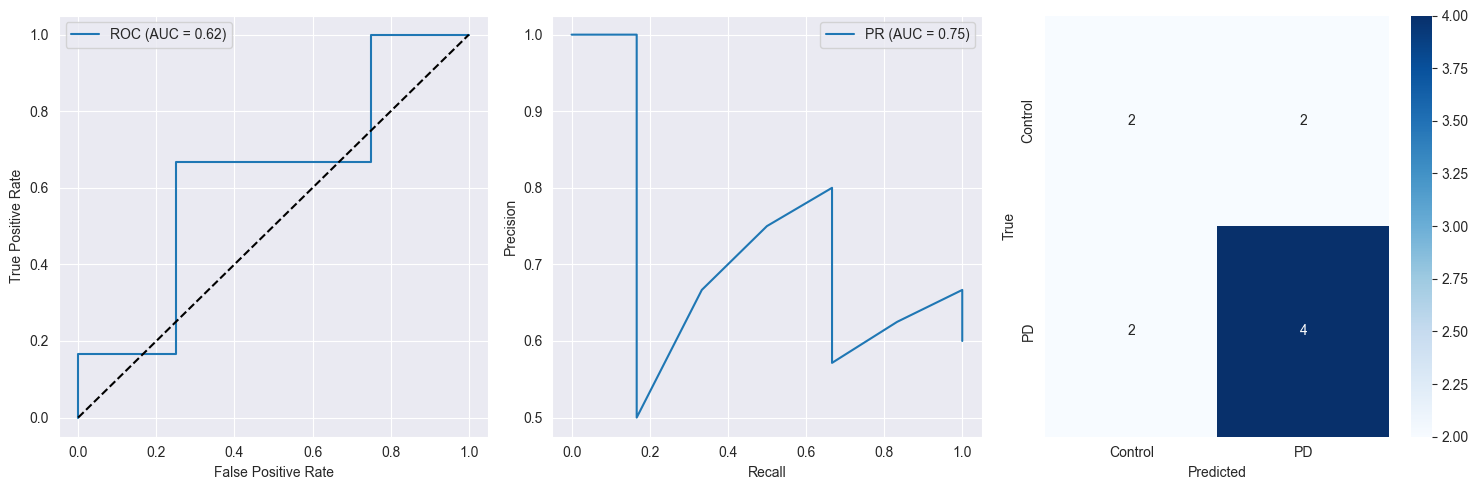

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y_test, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

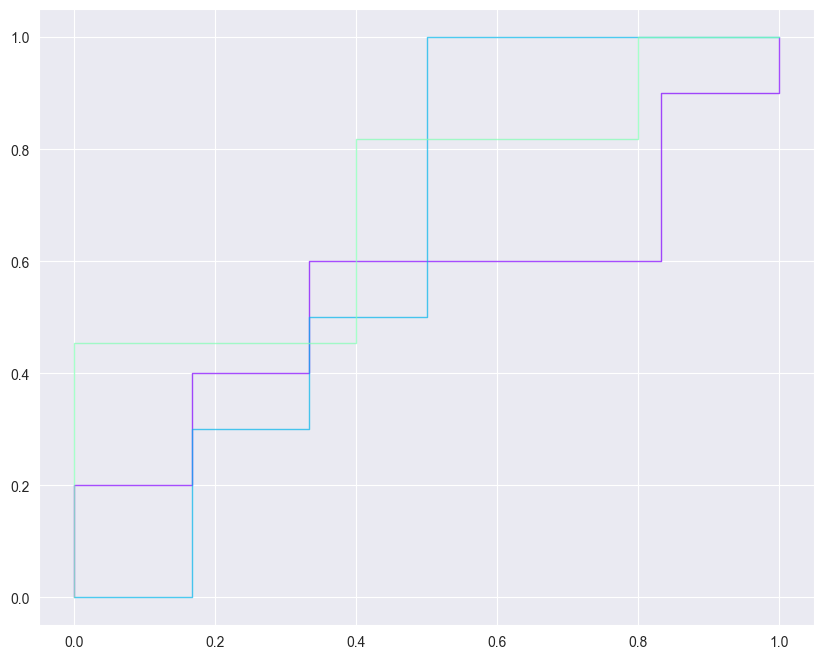

In [16]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = {'roc_auc': [], 'pr_auc': []}

plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, 5))

for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb_pipeline.fit(X_train, y_train)
    y_proba = xgb_pipeline.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_val, y_proba)
    pr_auc = average_precision_score(y_val, y_proba)
    cv_scores['roc_auc'].append(roc_auc)
    cv_scores['pr_auc'].append(pr_auc)

    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, color=colors[i], lw=1, alpha=0.7,
             label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

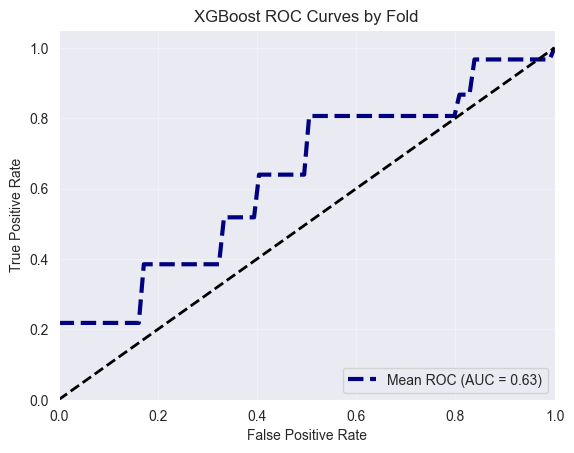

In [24]:
from scipy.interpolate import interp1d

mean_fpr = np.linspace(0, 1, 100)
tprs = []
for train_idx, val_idx in cv.split(X, y):
    y_proba = xgb_pipeline.fit(X.iloc[train_idx], y.iloc[train_idx]).predict_proba(X.iloc[val_idx])[:, 1]
    fpr, tpr, _ = roc_curve(y.iloc[val_idx], y_proba)
    interp_tpr = interp1d(fpr, tpr, bounds_error=False, fill_value=0)(mean_fpr)
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_auc = np.mean(cv_scores['roc_auc'])

plt.plot(mean_fpr, mean_tpr, color='navy', lw=3, linestyle='--',
         label=f'Mean ROC (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curves by Fold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [26]:
print("\nCross-validation results:")
print(f"ROC-AUC: {np.mean(cv_scores['roc_auc']):.3f} ± {np.std(cv_scores['roc_auc']):.3f}")
print(f"PR-AUC: {np.mean(cv_scores['pr_auc']):.3f} ± {np.std(cv_scores['pr_auc']):.3f}")


Cross-validation results:
ROC-AUC: 0.631 ± 0.065
PR-AUC: 0.770 ± 0.076


In [27]:
xgb_model = xgb_pipeline.named_steps['xgb']
importances = pd.DataFrame({
    'ensembl_id': consensus_genes.index,
    'gene_symbol': consensus_genes['gene_symbol'],
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

In [28]:
print("\nTop 40 important genes:")
print(importances.head(40)[['gene_symbol', 'importance']])


Top 40 important genes:
                       gene_symbol  importance
ENSG00000269181.1  ENSG00000269181    0.104426
ENSG00000250829.2  ENSG00000250829    0.096916
ENSG00000243415.2  ENSG00000243415    0.096071
ENSG00000249436.1           LNCBRM    0.083104
ENSG00000252008.1        RNU6-927P    0.080516
ENSG00000228955.2         RPL7AP82    0.072856
ENSG00000196812.4          ZSCAN16    0.046352
ENSG00000207115.1        RNU6-364P    0.045767
ENSG00000263327.6        TAPT1-AS1    0.043986
ENSG00000277241.1          FGFR3P4    0.036832
ENSG00000179066.8     LOC124904701    0.035835
ENSG00000213731.2          RAB5CP1    0.035741
ENSG00000283571.1  ENSG00000283571    0.031817
ENSG00000122585.7              NPY    0.028589
ENSG00000271357.1  ENSG00000271357    0.027502
ENSG00000238141.2        BRWD1-AS1    0.020634
ENSG00000232537.1  ENSG00000232537    0.020505
ENSG00000207403.1            Y_RNA    0.018580
ENSG00000268289.1  ENSG00000268289    0.015226
ENSG00000226904.1  ENSG00000226904 

/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_5272/1711848117.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


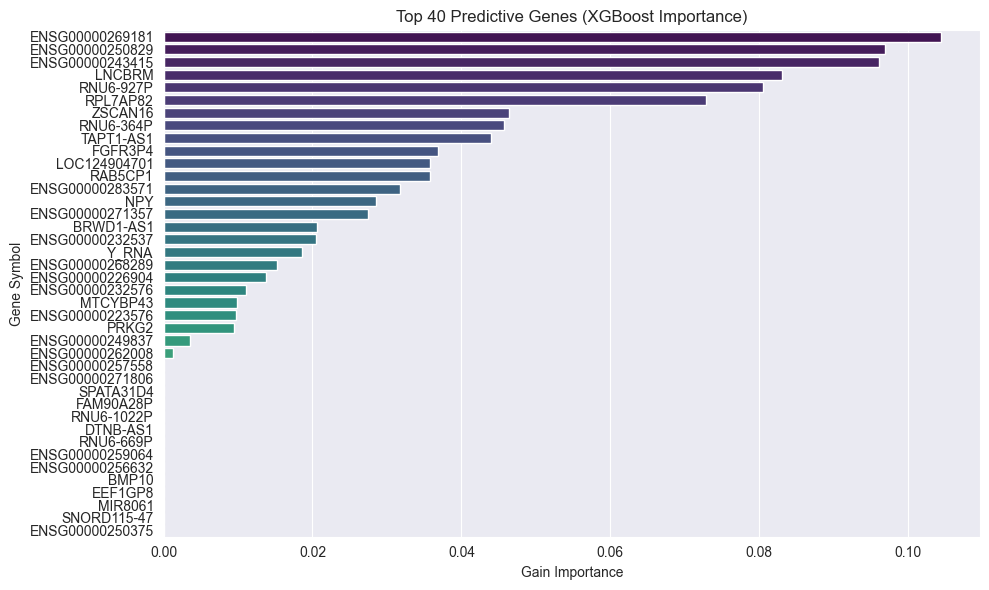

In [29]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=importances.head(40),
    x='importance',
    y='gene_symbol',
    palette='viridis'
)
plt.title('Top 40 Predictive Genes (XGBoost Importance)')
plt.xlabel('Gain Importance')
plt.ylabel('Gene Symbol')
plt.tight_layout()
plt.show()